In [1]:
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.datasets import boston_housing
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
import tensorflow as tf
import pandas as pd

## KERAS
from keras.optimizers import Adam, SGD
from keras.layers import Dense, BatchNormalization, Dropout, LayerNormalization
from keras.regularizers import l2

from keras.initializers import glorot_uniform
from sklearn.model_selection import KFold

from keras.callbacks import LearningRateScheduler

import matplotlib.pyplot as plt 


In [2]:
teste = pd.read_csv("../Classification/Corona_NLP_test.csv")
treino = pd.read_csv("../Classification/Corona_NLP_train.csv",encoding='latin-1')

data = pd.concat([teste,treino])
data = data.sample(frac=0.2, random_state=42)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8991 entries, 29256 to 21571
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       8991 non-null   int64 
 1   ScreenName     8991 non-null   int64 
 2   Location       7135 non-null   object
 3   TweetAt        8991 non-null   object
 4   OriginalTweet  8991 non-null   object
 5   Sentiment      8991 non-null   object
dtypes: int64(2), object(4)
memory usage: 491.7+ KB


In [3]:
data = data.drop(columns=[ "UserName","ScreenName","Location","TweetAt"], axis=1)

In [4]:
def categorize_sentiment(score):
    if score == 'Negative':
        return "Negative"
    elif score == 'Extremely Negative':
        return "Negative"
    elif score == 'Positive':
        return "Positive"
    elif score == 'Extremely Positive':
        return "Positive"
    else:
        return "Neutral"
    
    
data['Sentiment'] = data['Sentiment'].apply(categorize_sentiment)

In [5]:
# Fazer TOKENIZACAO das palavras
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def get_all_str(tweet):
    sentence = ''
    for words in tweet:
        sentence += words
    sentence = sentence.lower()
    return sentence
def get_str(lst):
    sentence = ''
    for char in lst:
        sentence += char+' '
    sentence = sentence.lower()
    return sentence

def get_word(text): 
    result = nltk.RegexpTokenizer(r'\w+').tokenize(text.lower())
    return result

def get_hashtag(text):
    result = nltk.RegexpTokenizer(r'(?<=#)\w+').tokenize(text.lower())
    return result

def get_mention(text):
    result = nltk.RegexpTokenizer(r'(?<=@)\w+').tokenize(text.lower())
    return result 

def stopword_list(stop):
    lst = stopwords.words('english')
    for stopword in stop:
        lst.append(stopword)
    return lst

def remove_stopword(stopwords, lst):    
    stoplist = stopword_list(stopwords)
    txt = ''
    for idx in range(len(lst)):
        txt += lst[idx]
        txt += '\n'
    cleanwordlist = [word for word in txt.split() if word not in stoplist] 
#     print(stoplist)
    return cleanwordlist

def pos_remove_noun(tagged):
    remove_noun = [word for word,pos in tagged if pos not in ['NN','NNS','NNP','NNPS']]
    txt = ''
    for i in range(len(remove_noun)):
        txt += remove_noun[i]
        txt += '\n'
    return cleanwordlist

def lemmatization(words):
    lemm = WordNetLemmatizer()
    tokens = [lemm.lemmatize(word) for word in words]
#     txt= ' '.join(tokens)
    return tokens

In [7]:
def preprocessing(text):
    words = get_word(text)
    lemma = lemmatization(words)
    removed = remove_stopword(['http','ly'],lemma)
    return removed

data['OriginalTweet'] = data['OriginalTweet'].apply(preprocessing)
data['OriginalTweet'] = data['OriginalTweet'].apply(get_str)

In [8]:
X = data.drop(columns=["Sentiment"])
y = data["Sentiment"]

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

Tfidf = TfidfVectorizer(stop_words='english', norm='l2' )
X = Tfidf.fit_transform(X["OriginalTweet"]).toarray()

In [10]:
from sklearn.preprocessing import  LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Testes de funções de ativação na camada de saída

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Relu

In [15]:
def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(len(np.unique(y)), activation='relu'))
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')

57/57 [==============================] - 1s 9ms/step - loss: 1.0986 - accuracy: 0.3763
Loss: 1.0986127853393555, Accuracy: 0.3763201832771301
57/57 [==============================] - 1s 8ms/step - loss: 1.0974 - accuracy: 0.3832
Loss: 1.0973907709121704, Accuracy: 0.38320356607437134
57/57 [==============================] - 1s 9ms/step - loss: 1.0986 - accuracy: 0.3815
Loss: 1.0986127853393555, Accuracy: 0.38153505325317383
57/57 [==============================] - 1s 9ms/step - loss: 1.0986 - accuracy: 0.3771
Loss: 1.0986127853393555, Accuracy: 0.3770856559276581
57/57 [==============================] - 1s 11ms/step - loss: 1.0986 - accuracy: 0.3643
Loss: 1.0986127853393555, Accuracy: 0.3642936646938324


## Selu

In [16]:
def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=X.shape[1], activation='selu'))
    model.add(Dense(16, activation='selu'))
    model.add(Dense(len(np.unique(y)), activation='selu'))
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')

57/57 [==============================] - 0s 6ms/step - loss: 1.0986 - accuracy: 0.1940
Loss: 1.0986127853393555, Accuracy: 0.19399666786193848
57/57 [==============================] - 1s 9ms/step - loss: 1.0986 - accuracy: 0.4627
Loss: 1.0986127853393555, Accuracy: 0.4627363681793213
57/57 [==============================] - 1s 9ms/step - loss: 1.0986 - accuracy: 0.3915
Loss: 1.0986127853393555, Accuracy: 0.3915461599826813
57/57 [==============================] - 1s 9ms/step - loss: 1.0986 - accuracy: 0.3765
Loss: 1.0986127853393555, Accuracy: 0.3765294849872589
57/57 [==============================] - 1s 9ms/step - loss: 1.0986 - accuracy: 0.4422
Loss: 1.0986127853393555, Accuracy: 0.44215795397758484


## Sigmoid

In [17]:

def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=X.shape[1], activation='selu'))
    model.add(Dense(16, activation='selu'))
    model.add(Dense(len(np.unique(y)), activation='sigmoid'))
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')

57/57 [==============================] - 0s 6ms/step - loss: 2.0706 - accuracy: 0.6626
Loss: 2.070641040802002, Accuracy: 0.6625903248786926
57/57 [==============================] - 1s 10ms/step - loss: 1.8786 - accuracy: 0.6885
Loss: 1.8785759210586548, Accuracy: 0.6885428428649902
57/57 [==============================] - 1s 10ms/step - loss: 2.0542 - accuracy: 0.6641
Loss: 2.0541932582855225, Accuracy: 0.6640712022781372
57/57 [==============================] - 0s 4ms/step - loss: 2.0911 - accuracy: 0.6724
Loss: 2.091059923171997, Accuracy: 0.6724137663841248
57/57 [==============================] - 0s 4ms/step - loss: 1.9951 - accuracy: 0.6707
Loss: 1.995059609413147, Accuracy: 0.6707452535629272


## Softplus

In [18]:
def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=X.shape[1], activation='selu'))
    model.add(Dense(16, activation='selu'))
    model.add(Dense(len(np.unique(y)), activation='softplus'))
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')

57/57 [==============================] - 0s 5ms/step - loss: 1.9487 - accuracy: 0.6598
Loss: 1.948716640472412, Accuracy: 0.6598110198974609
57/57 [==============================] - 0s 5ms/step - loss: 1.7728 - accuracy: 0.6802
Loss: 1.7728073596954346, Accuracy: 0.6802002191543579
57/57 [==============================] - 1s 9ms/step - loss: 1.8522 - accuracy: 0.6580
Loss: 1.8522000312805176, Accuracy: 0.6579532623291016
57/57 [==============================] - 0s 6ms/step - loss: 1.9673 - accuracy: 0.6674
Loss: 1.9672644138336182, Accuracy: 0.6674082279205322
57/57 [==============================] - 0s 6ms/step - loss: 1.9095 - accuracy: 0.6591
Loss: 1.9094882011413574, Accuracy: 0.6590656042098999


## Softmax

In [14]:


def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=X.shape[1], activation='selu'))
    model.add(Dense(16, activation='selu'))
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')

57/57 [==============================] - 1s 9ms/step - loss: 2.0567 - accuracy: 0.6631
Loss: 2.0566790103912354, Accuracy: 0.6631461977958679
57/57 [==============================] - 2s 22ms/step - loss: 1.8567 - accuracy: 0.6880
Loss: 1.8566888570785522, Accuracy: 0.6879866719245911
57/57 [==============================] - 0s 7ms/step - loss: 2.0353 - accuracy: 0.6707
Loss: 2.03527569770813, Accuracy: 0.6707452535629272
57/57 [==============================] - 0s 7ms/step - loss: 2.0986 - accuracy: 0.6758
Loss: 2.098640203475952, Accuracy: 0.6757508516311646
57/57 [==============================] - 0s 7ms/step - loss: 2.0124 - accuracy: 0.6746
Loss: 2.012434720993042, Accuracy: 0.6746385097503662


<function matplotlib.pyplot.show(close=None, block=None)>

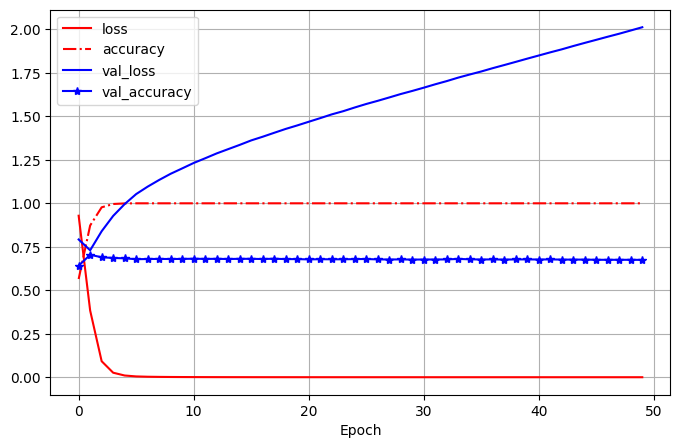

In [15]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), grid=True, xlabel="Epoch", style=["r-", "r-.", "b-", "b-*"]
)
plt.show

# Aplição do modelo com SoftMax

## Glorot

In [16]:
def create_model():
    model = Sequential()
    model.add(tf.keras.Input(shape=X_train.shape[1:]))
    model.add(Dense(64, activation='selu',kernel_initializer=glorot_uniform(seed = 50)))
    model.add(Dense(16, activation='selu',kernel_initializer=glorot_uniform(seed = 50)))
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')

57/57 [==============================] - 1s 10ms/step - loss: 2.1468 - accuracy: 0.6693
Loss: 2.1468119621276855, Accuracy: 0.6692606806755066
57/57 [==============================] - 1s 13ms/step - loss: 1.9615 - accuracy: 0.6835
Loss: 1.9615148305892944, Accuracy: 0.6835372447967529
57/57 [==============================] - 1s 16ms/step - loss: 2.1062 - accuracy: 0.6663
Loss: 2.1061503887176514, Accuracy: 0.6662958860397339
57/57 [==============================] - 1s 16ms/step - loss: 2.1801 - accuracy: 0.6746
Loss: 2.180081367492676, Accuracy: 0.6746385097503662
57/57 [==============================] - 1s 9ms/step - loss: 2.0807 - accuracy: 0.6680
Loss: 2.080650568008423, Accuracy: 0.6679643988609314


<function matplotlib.pyplot.show(close=None, block=None)>

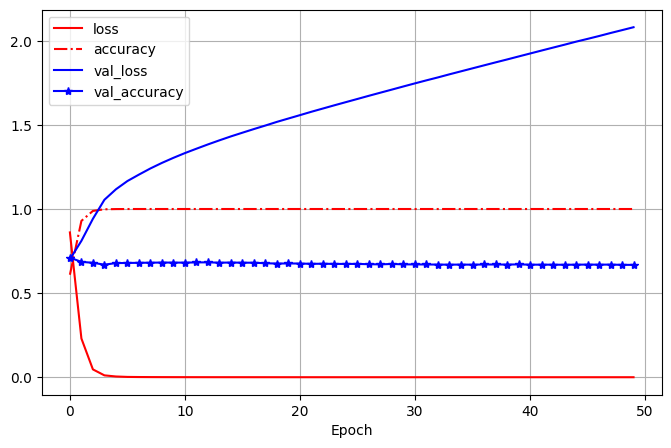

In [17]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), grid=True, xlabel="Epoch", style=["r-", "r-.", "b-", "b-*"]
)
plt.show

## Batch Norm

In [18]:
def create_model():
    model = Sequential()
    model.add(tf.keras.Input(shape=X_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')


57/57 [==============================] - 1s 11ms/step - loss: 3.6542 - accuracy: 0.6203
Loss: 3.6541717052459717, Accuracy: 0.6203446388244629
57/57 [==============================] - 1s 8ms/step - loss: 3.1132 - accuracy: 0.6157
Loss: 3.1131789684295654, Accuracy: 0.6156840920448303
57/57 [==============================] - 1s 9ms/step - loss: 3.6741 - accuracy: 0.6301
Loss: 3.6740641593933105, Accuracy: 0.6301445960998535
57/57 [==============================] - 1s 8ms/step - loss: 4.0146 - accuracy: 0.6301
Loss: 4.014561176300049, Accuracy: 0.6301445960998535
57/57 [==============================] - 1s 9ms/step - loss: 3.4431 - accuracy: 0.6624
Loss: 3.443060874938965, Accuracy: 0.6624026894569397


<function matplotlib.pyplot.show(close=None, block=None)>

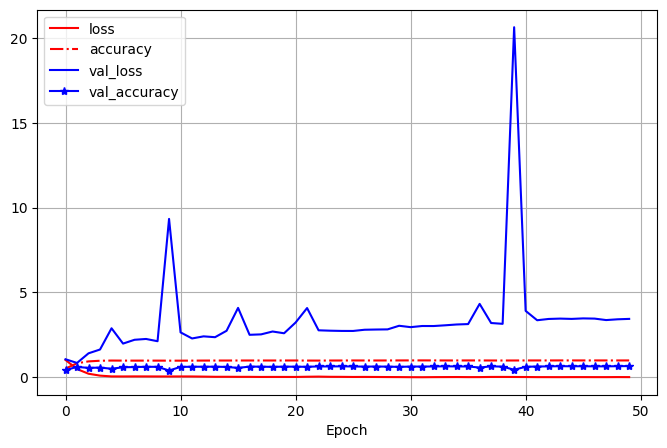

In [19]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), grid=True, xlabel="Epoch", style=["r-", "r-.", "b-", "b-*"]
)
plt.show

## Power Scheduling

In [20]:

def power_scheduler(epoch, lr):
    power = 0.5  # You can adjust the power value
    return lr * np.power(1.0 / (1.0 + epoch), power)

def create_model():
    model = Sequential()
    model.add(tf.keras.Input(shape=X_train.shape[1:]))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    lr_scheduler = LearningRateScheduler(power_scheduler)
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[lr_scheduler], validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')
    

57/57 [==============================] - 1s 9ms/step - loss: 0.6961 - accuracy: 0.7054
Loss: 0.6960605978965759, Accuracy: 0.7053918838500977
57/57 [==============================] - 0s 6ms/step - loss: 0.6811 - accuracy: 0.7275
Loss: 0.6810728311538696, Accuracy: 0.7274749875068665
57/57 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.7186
Loss: 0.6905524134635925, Accuracy: 0.718576192855835
57/57 [==============================] - 0s 6ms/step - loss: 0.7475 - accuracy: 0.6986
Loss: 0.7475280165672302, Accuracy: 0.6985539197921753
57/57 [==============================] - 0s 5ms/step - loss: 0.7009 - accuracy: 0.7164
Loss: 0.7009326219558716, Accuracy: 0.7163515090942383


<function matplotlib.pyplot.show(close=None, block=None)>

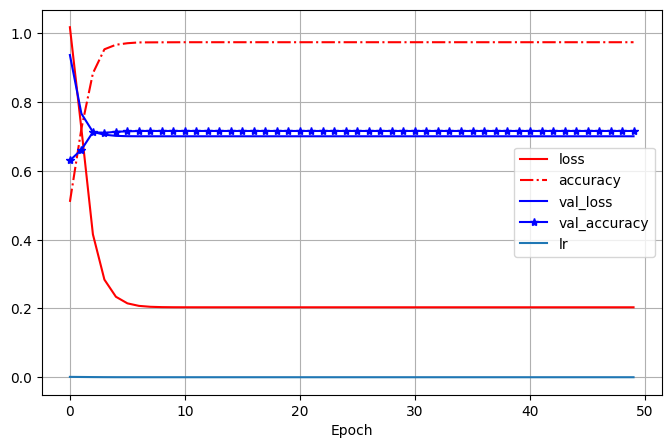

In [21]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), grid=True, xlabel="Epoch", style=["r-", "r-.", "b-", "b-*"]
)
plt.show

## Exponencial Scheduling

In [22]:
def exp_schedule(epoch, lr):
    k = 0.1  # You can adjust this parameter based on your needs
    return lr * np.exp(-k * epoch)

def create_model():
    model = Sequential()
    model.add(tf.keras.Input(shape=X_train.shape[1:]))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    lr_schedule = LearningRateScheduler(exp_schedule)
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[lr_schedule], validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')    

57/57 [==============================] - 0s 6ms/step - loss: 0.7910 - accuracy: 0.6904
Loss: 0.790953516960144, Accuracy: 0.6903835535049438
57/57 [==============================] - 0s 6ms/step - loss: 0.7550 - accuracy: 0.7208
Loss: 0.7549991607666016, Accuracy: 0.7208008766174316
57/57 [==============================] - 0s 6ms/step - loss: 0.7866 - accuracy: 0.7030
Loss: 0.7865644097328186, Accuracy: 0.7030033469200134
57/57 [==============================] - 0s 7ms/step - loss: 0.7990 - accuracy: 0.6958
Loss: 0.7989802956581116, Accuracy: 0.6957730650901794
57/57 [==============================] - 0s 5ms/step - loss: 0.7737 - accuracy: 0.7102
Loss: 0.7737125754356384, Accuracy: 0.7102335691452026


<function matplotlib.pyplot.show(close=None, block=None)>

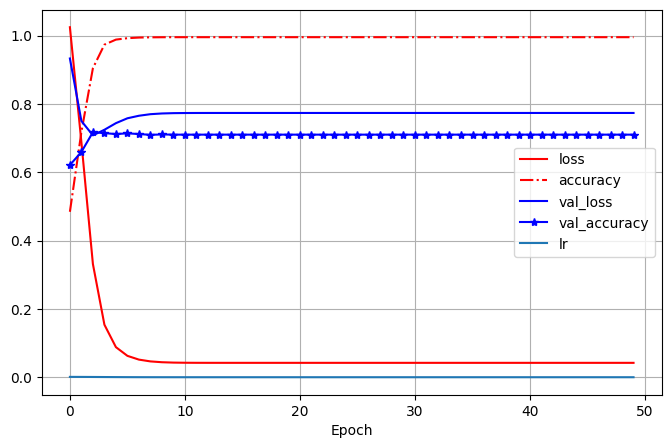

In [23]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), grid=True, xlabel="Epoch", style=["r-", "r-.", "b-", "b-*"]
)
plt.show

## L2

In [14]:
def create_model():
    model = Sequential()
    model.add(tf.keras.Input(shape=X_train.shape[1:]))
    model.add(Dense(64, activation='selu',kernel_regularizer=l2()))
    model.add(Dense(16, activation='selu',kernel_regularizer=l2()))
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')


57/57 [==============================] - 1s 11ms/step - loss: 1.1271 - accuracy: 0.6870
Loss: 1.127094030380249, Accuracy: 0.6870483756065369
57/57 [==============================] - 1s 8ms/step - loss: 1.1049 - accuracy: 0.6941
Loss: 1.104949951171875, Accuracy: 0.6941045522689819
57/57 [==============================] - 1s 10ms/step - loss: 1.1300 - accuracy: 0.6863
Loss: 1.1300016641616821, Accuracy: 0.6863181591033936
57/57 [==============================] - 0s 7ms/step - loss: 1.1658 - accuracy: 0.6869
Loss: 1.1657688617706299, Accuracy: 0.6868743300437927
57/57 [==============================] - 0s 7ms/step - loss: 1.1117 - accuracy: 0.6913
Loss: 1.1116520166397095, Accuracy: 0.6913236975669861


<function matplotlib.pyplot.show(close=None, block=None)>

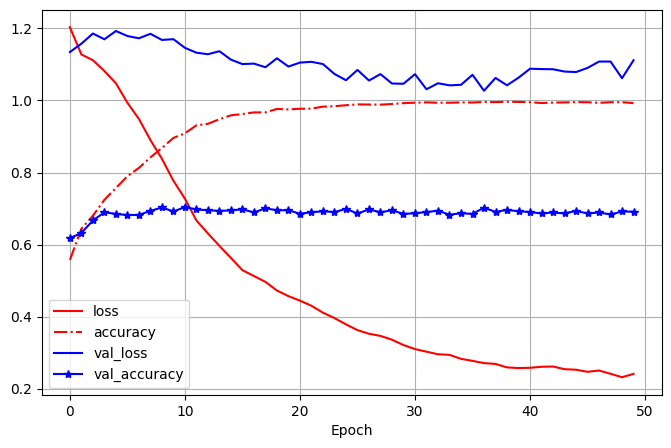

In [15]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), grid=True, xlabel="Epoch", style=["r-", "r-.", "b-", "b-*"]
)
plt.show

## Dropout

In [16]:
def create_model():
    model = Sequential()
    model.add(tf.keras.Input(shape=X_train.shape[1:]))
    model.add(Dropout(0.2, seed=42))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2, seed=42))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2, seed=42))
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')    

57/57 [==============================] - 1s 7ms/step - loss: 1.9185 - accuracy: 0.6292
Loss: 1.9185268878936768, Accuracy: 0.629238486289978
57/57 [==============================] - 0s 6ms/step - loss: 1.7203 - accuracy: 0.6468
Loss: 1.7203460931777954, Accuracy: 0.6468297839164734
57/57 [==============================] - 0s 7ms/step - loss: 1.9590 - accuracy: 0.6396
Loss: 1.9590232372283936, Accuracy: 0.6395995616912842
57/57 [==============================] - 1s 8ms/step - loss: 1.9031 - accuracy: 0.6352
Loss: 1.9031163454055786, Accuracy: 0.6351501941680908
57/57 [==============================] - 0s 6ms/step - loss: 1.8219 - accuracy: 0.6440
Loss: 1.8218904733657837, Accuracy: 0.6440489292144775


<function matplotlib.pyplot.show(close=None, block=None)>

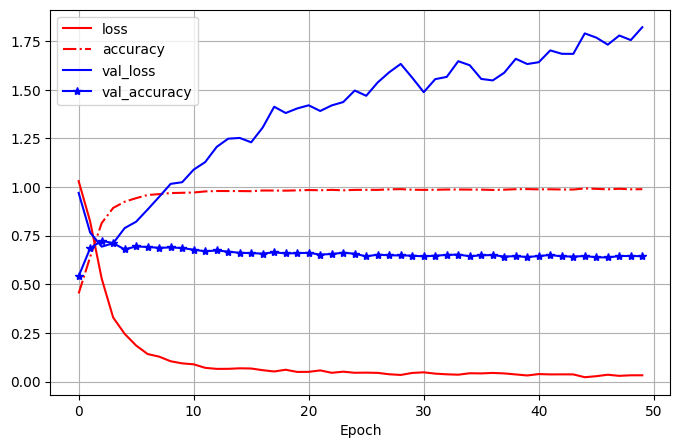

In [17]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), grid=True, xlabel="Epoch", style=["r-", "r-.", "b-", "b-*"]
)
plt.show

# Aplicação de "todos"

In [18]:
def power_scheduler(epoch, lr):
    power = 0.5  # You can adjust the power value
    return lr * np.power(1.0 / (1.0 + epoch), power)

def create_model():
    model = Sequential()
    model.add(tf.keras.Input(shape=X_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='selu',kernel_initializer=glorot_uniform(seed = 50),kernel_regularizer=l2()))
    model.add(BatchNormalization())
    model.add(Dense(52, activation='selu',kernel_initializer=glorot_uniform(seed = 50),kernel_regularizer=l2()))
    model.add(BatchNormalization())
    model.add(Dense(len(np.unique(y)), activation='softmax',kernel_regularizer=l2(0.1),kernel_initializer=glorot_uniform(seed = 50)))
    model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


train_scores = []
test_scores = []
# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_model()
    lr_scheduler = LearningRateScheduler(power_scheduler)
    # model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[lr_scheduler], validation_data=(X_test, y_test), verbose=0)
    train_scores.append(history.history['accuracy'][-1])
    test_scores.append(history.history['val_accuracy'][-1])
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')    

57/57 [==============================] - 1s 9ms/step - loss: 1.5166 - accuracy: 0.6537
Loss: 1.516557216644287, Accuracy: 0.6536964774131775
57/57 [==============================] - 1s 15ms/step - loss: 1.4141 - accuracy: 0.6719
Loss: 1.4141255617141724, Accuracy: 0.6718575954437256
57/57 [==============================] - 1s 12ms/step - loss: 1.4882 - accuracy: 0.6502
Loss: 1.4881776571273804, Accuracy: 0.6501668691635132
57/57 [==============================] - 1s 11ms/step - loss: 1.4840 - accuracy: 0.6657
Loss: 1.4839502573013306, Accuracy: 0.6657397150993347
57/57 [==============================] - 1s 11ms/step - loss: 1.4529 - accuracy: 0.6652
Loss: 1.452927827835083, Accuracy: 0.6651835441589355


<function matplotlib.pyplot.show(close=None, block=None)>

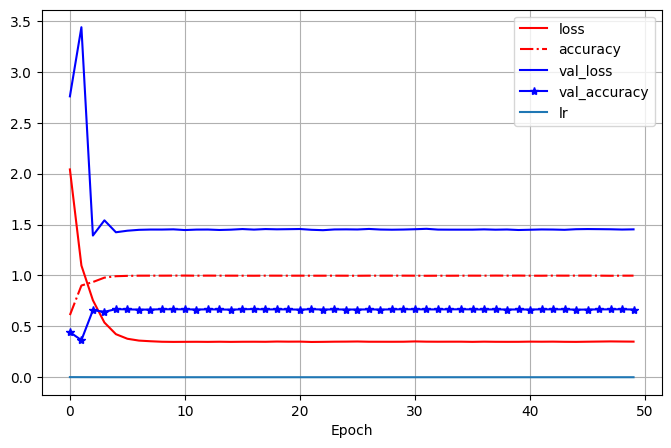

In [19]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), grid=True, xlabel="Epoch", style=["r-", "r-.", "b-", "b-*"]
)
plt.show